# **HW1**

#### **Imports**

In [1]:
import cv2
import math
import random

import numpy as np 
from numpy            import pi 
from numpy.random     import MT19937, RandomState, SeedSequence

from matplotlib       import pyplot as plt
from scipy.signal     import  convolve2d
from sklearn.metrics  import mean_squared_error as mse
from PIL              import Image
from torch.utils.data import DataLoader, Dataset

import keras
from keras.datasets   import mnist

%matplotlib inline

## **Task \#1 :  MNIST 0-100**

#### **Import**
x_{train/test} will hold the images\
y_{train/test} will hold the labels.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() 

### **Printing By Target**
Here we will print 5 samples of each number.


5 samples of 0


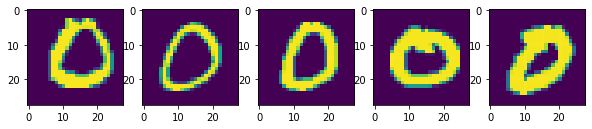


5 samples of 1


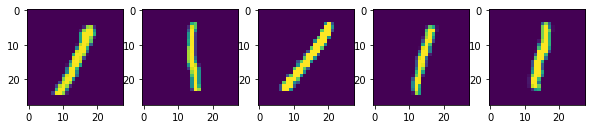


5 samples of 2


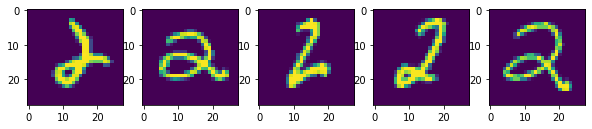


5 samples of 3


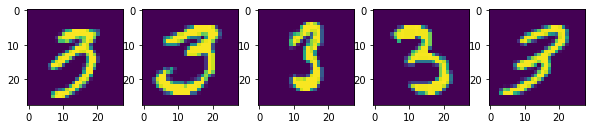


5 samples of 4


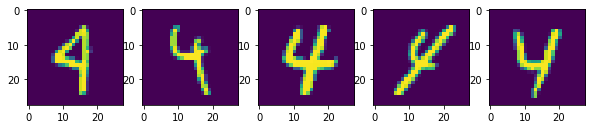


5 samples of 5


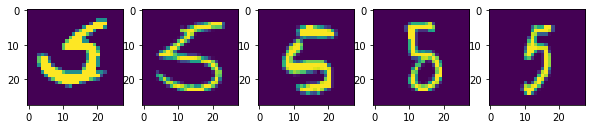


5 samples of 6


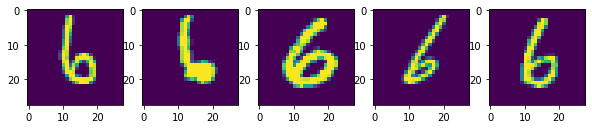


5 samples of 7


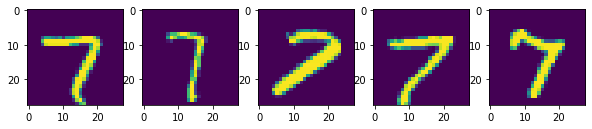


5 samples of 8


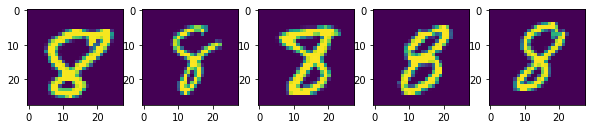


5 samples of 9


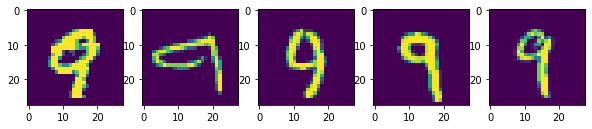

In [3]:
# Prints one target
def print_by_target(x_train, y_train, target, amount=5):
  print('\n' + str(amount) + " samples of " + str(target)) # Header
  fig = plt.figure(figsize=(10, 8))
  for i in range(amount):
    idx = random.randint(1, 60000)
    while y_train[idx] != target:
      idx = random.randint(1, 60000)
    fig.add_subplot(1, 5, i+1)
    plt.imshow(x_train[idx])
  plt.show()

# All targets
def print_targets(x_train, y_train):
  for i in range(10):
    print_by_target(x_train, y_train, i)

print_targets(x_train, y_train)

### **3 Digits MNist**

In [4]:
# make a new 3 digits number
def number_3dig(imgs, targets): #imgs as tupe
  new_img = np.concatenate(imgs, axis=1)
  new_target = "" + str(targets[0]) + str(targets[1]) + str(targets[2]) 
  return new_img, new_target

##### Example

504


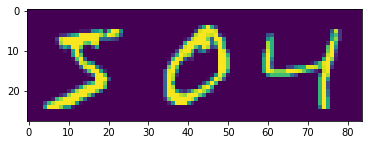

In [5]:
# Example
imgs = (x_train[0], x_train[1], x_train[2])
targets = [y_train[0], y_train[1], y_train[2]]
new_imgs, new_target = number_3dig(imgs, targets)
print(new_target)
plt.imshow(new_imgs)
plt.show()

#### **Filter Functions**
In this task, we will use previous filters.

We chose to use the filters of:
* **Gaussian-Blur**
* **Median Blur**
* **Sharpening**
* **Rotation** (limited angles)

The decided to not use some filters from the following resons:
* **Flip (Vertically or Horizontally)** - Flipping some data might be mix with another data (like the number 9 could look like 6, or 2 could look like 5).
* **Zoom** - some data might mix with another data (like the numbers 9,6 could look like 0).
* **Crop** - some data might mix with another data (like the numbers 8 could look like 3 or 7 could look like 1).
* **Limited Rotation** - From certian angle, the rotation will look like flipping

##### Helpers

In [6]:
# Helping matrixes
sobelX = np.asarray(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]), dtype=np.float32) * 1/16
sobelY = np.asarray(([-1,-2,-1], [0, 0, 0], [1, 2, 1]), dtype=np.float32) * 1/16
laplacian = np.array(([0, -1, 0], [-1, 5, -1], [0, -1, 0]), dtype='int') * 0.25 

# Calculates padding
def calculate_padding_single_dim(dim_in, dim_out, kernel_size):
  return  int(np.ceil((dim_out - dim_in + kernel_size) /2 ) -1)  

##### **Gaussian-Blur**

In [7]:
# Gaussian-Blur's filter 
def get_gaussian_filter(kernel_size, sigma):
  g_filter = np.zeros((kernel_size, kernel_size), np.float32)
  x, y = kernel_size // 2 , kernel_size // 2
  for i in range(-x, x+1):
    for j in range(-y, y+1):
      x1 = 2 * pi *(sigma**2)
      x2 = np.exp(-(x**2 + y**2)/(2* sigma**2))
      g_filter[i+x, j+y] = (1/x1)*x2
  return g_filter

# Calculation
def gaussian_blur(img, kernel_size, sigma):
  g_filter = get_gaussian_filter(kernel_size, sigma)
  new_img = convolve2d(img, g_filter, mode='same')
  return new_img

##### **Median-Blur**

In [8]:
def median_blur(img,kernel_size):
  x, y = img.shape
  new_img = np.zeros_like(img)
  pad_y = calculate_padding_single_dim(y, y, kernel_size)
  pad_x = calculate_padding_single_dim(x, x, kernel_size)
  p_img = np.pad(img, [pad_y, pad_x]) # Padded Image

  for i in range(new_img.shape[0]):
    for j in range(new_img.shape[1]):
      new_img[i, j] = np.median(p_img [i:i + kernel_size ,j:j + kernel_size])
  return new_img

##### **Sharpening**

In [9]:
def sharp_img(img, kernel=laplacian):
  sharpened_img = convolve2d(img, kernel) # img convolation with matrix
  return np.abs(sharpened_img) # values are positive

##### **Rotation**

In [10]:
def rotate(img: np.ndarray, angle: int):
  h, w = img.shape[0], img.shape[1]
  res_img = np.zeros(img.shape) # New image creation
  # Angle's calculations
  angle = np.deg2rad(angle)
  cos_a = np.cos(angle)
  sin_a = np.sin(angle)
  # Image's center
  midY = round(((h + 1) / 2) - 1)
  midX = round(((w + 1) / 2) - 1)
  # Result's center
  yCenter = round((midY * cos_a) - (midX * sin_a))
  xCenter = round((midY * sin_a) + (midX * cos_a))

  for y in range(h):
    for x in range(w):
      nX = round((y * sin_a) + (x * cos_a)) - xCenter + midX
      nY = round((y * cos_a) - (x * sin_a)) - yCenter + midY
      if (w > nX and (nX > 0)) and (h > nY and (nY > 0)):
        res_img[nY ,nX] = img[y ,x]
  
  return res_img.astype(np.uint8)

#### **Augmentations**

After choosing our filters, we used some of them together with different variables, and created some augmentations.

Those are the chosen augmentations:


| Agmnt 	| Gaussian-Blur  	| Median-Blur 	| Sharpening 	| Rotate 	|
|--------	|----------------	|-------------	|------------	|--------	|
| **1**  	| k=3 , sig=0.5  	| x           	| x          	| x      	|
| **2**  	| x              	| k=3         	| x          	| x      	|
| **3**  	| x              	| x           	| x          	| 15     	|
| **4**  	| x              	| x           	| laplacian  	| x      	|
| **5**  	| k=3 , sig=0.9  	| k=3         	| sobelX      | 10     	|
| **6**  	| k=3 , sig=0.6  	| k=5         	| sobelY      | 13     	|
| **7**  	| k=5 , sig=0.8  	| x           	| x         	| x     	|
| **8**  	| k=3 , sig=0.7  	| x           	| x         	| -5    	|
| **9**  	| k=5 , sig=0.6  	| k=3         	| laplacian   | 30     	|
| **10** 	| k=3 , sig=0.6  	| k=7         	| sobelX     	| x     	|
| **11** 	| x              	| k=5         	| sobelY     	| 12     	|
| **12** 	| x             	| k=3         	| laplacian  	| -10    	|
| **13** 	| x              	| k=3         	| sobelX     	| 20     	|
| **14** 	| k=3 , sig=0.75 	| x           	| sobelY     	| 10     	|
| **15** 	| x             	| x           	| laplacian  	| -10    	|



##### **Creating Augmentations**

In [11]:
# Creates Augmentation by filter's variables
def agmnt_img(img, gaus_k=0, gaus_sig=0, med=0, shrp=0, rot=0):
  n_img = img
  if gaus_k != 0:
    n_img = gaussian_blur(n_img, gaus_k, gaus_sig)
  if med != 0:
    n_img = median_blur(n_img, med)
  if shrp != 0:
    if shrp == 'sx':
      n_img = sharp_img(n_img, kernel=sobelX)
    elif shrp == 'sy':
      n_img = sharp_img(n_img, kernel=sobelX)
    else:
      n_img = sharp_img(n_img)
  if rot != 0 : 
    n_img = rotate(n_img, rot)
  return n_img

In [12]:
# Every chosen image will be sampled by the following augmentations
def img_sampling(img):
  agm_imgs = []
  
  # 1st filter
  agm_imgs.append(agmnt_img(img, gaus_k=3, gaus_sig=0.5))
  # 2nd filter
  agm_imgs.append(agmnt_img(img, med=3))
  # 3rd filter
  agm_imgs.append(agmnt_img(img, rot=15))
  # 4th filter
  agm_imgs.append(agmnt_img(img, shrp='lp'))
  # 5th filter
  agm_imgs.append(agmnt_img(img, gaus_k=3, gaus_sig=0.9, med=3 ,shrp='sx', rot=10))
  # 6th filter
  agm_imgs.append(agmnt_img(img, gaus_k=3, gaus_sig=0.6, med=5 ,shrp='sy', rot=13))
  # 7th filter
  agm_imgs.append(agmnt_img(img, gaus_k=5, gaus_sig=0.8))
  # 8th filter
  agm_imgs.append(agmnt_img(img, gaus_k=3, gaus_sig=0.7, rot=-5))
  # 9th filter
  agm_imgs.append(agmnt_img(img, gaus_k=5, gaus_sig=0.6, med=3, shrp='lp'))
  # 10th filter
  agm_imgs.append(agmnt_img(img, gaus_k=3, gaus_sig=0.6, med=7, shrp='sx'))
  # 11th filter
  agm_imgs.append(agmnt_img(img, med=5, shrp='sy', rot=12))
  # 12th filter
  agm_imgs.append(agmnt_img(img, med=3, shrp='lp', rot=-10))
  # 13th filter
  agm_imgs.append(agmnt_img(img, med=3, shrp='sx', rot=20))
  # 14th filter
  agm_imgs.append(agmnt_img(img, gaus_k=3, gaus_sig=0.75, shrp='sy', rot=10))
  # 15th filter
  agm_imgs.append(agmnt_img(img, shrp='lp', rot=-10))

  return agm_imgs # Returns all augmentations

##### **Create Dictionay**
Will help us when we create the classes

In [13]:
# split MNIST dataset to dictionary by values
def digits_dictionary(x_train, y_train):
  d_digits = {i : [] for i in range(10)}
  for i in range(len(y_train)):
    pos = y_train[i]
    d_digits[pos].append(x_train[i])
  return d_digits

##### **Sampeling & Class Creation**

In [14]:
# Will return 267*16 (=4272) samples (include the "originals") for each class
def sampling(imgs): 
  samples = []
  samples = imgs
  for img in imgs:
    samples = samples + img_sampling(img)
  return samples

In [15]:
# Creates class of 3digits number, will return array of tuples(img and target)
def create_3digit_class(dct, hnd_d, ten_d, sgl_d):
  # 4000 examples // 15 filters = 267 examples
  imgs = [] # images list
  label = hnd_d*100 + ten_d*10 + sgl_d
  # Image creation
  for i in range(4000):
    # print(hnd_d, ten_d, sgl_d)
    idx1, idx2, idx3 = random.randint(0, len(dct[hnd_d])-1), random.randint(0, len(dct[ten_d])-1), random.randint(0, len(dct[sgl_d])-1)
    n3_img, n3_target = number_3dig([dct[hnd_d][idx1], dct[ten_d][idx2], dct[sgl_d][idx3]], [hnd_d, ten_d, sgl_d])
    imgs.append((n3_img, label))
  return imgs

def create_digits_calsses(dct):
  nw_cls = []
  for i in range(100):
    sgl_d = int(i/10)
    ten_d = int(int(i/10) %10)
    hnd_d = int(i/100)
    nw_cls.append(create_3digit_class(dct, hnd_d, ten_d, sgl_d))
  return nw_cls

#### **Final Classes**

In [16]:
def print_num(dct, new_cls):
  num = random.randint(0,100)
  print(new_cls[num][5][1]) 
  plt.imshow(new_cls[num][5][0])
  plt.show()

##### Printing Random Results

55


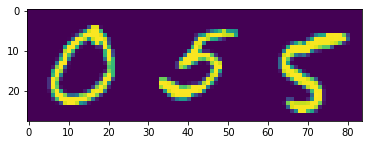

55


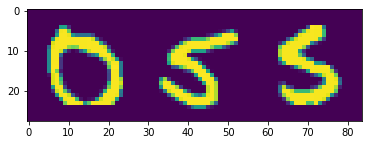

0


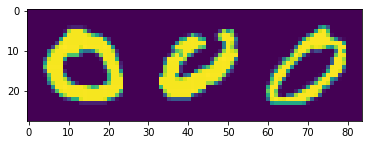

11


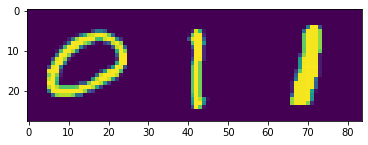

66


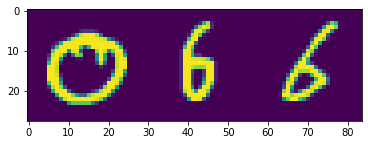

55


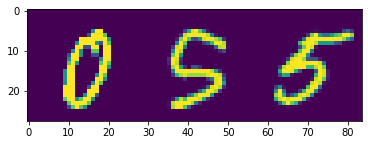

0


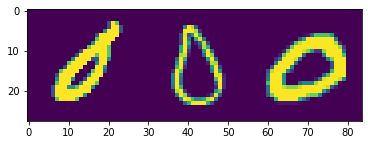

99


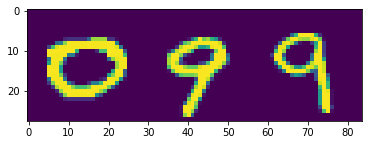

22


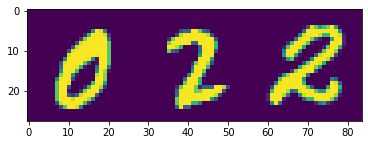

11


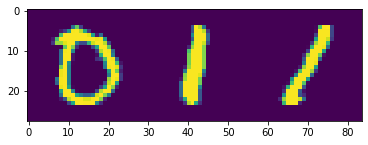

In [17]:
dct = digits_dictionary(x_train, y_train)
new_cls = create_digits_calsses(dct)
for _ in range(10):
  print_num(dct, new_cls)

In [18]:
def print_num_fixed(num):
  plt.imshow(num)
  plt.show()

Use the augmentations you created on lab 3 on your new dataset and show some results and
explain which augmentations are applicable to this specific dataset, which are not and why

99


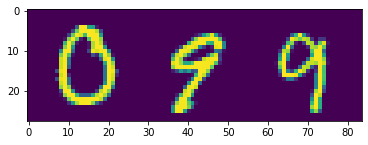

99


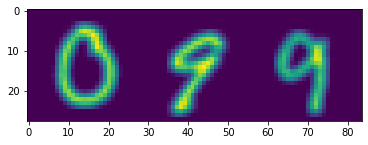

99


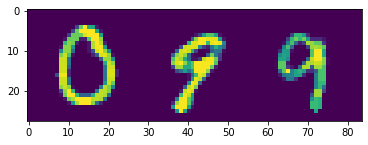

99


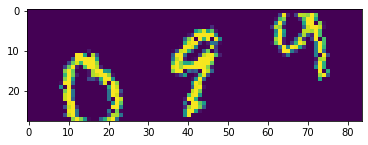

99


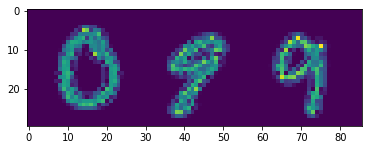

99


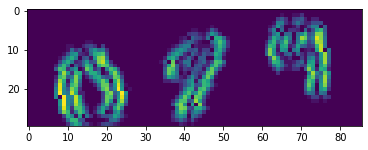

99


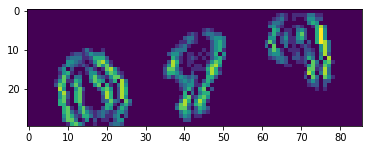

99


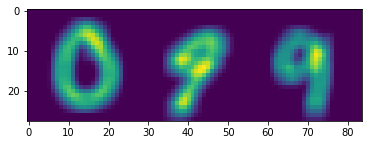

99


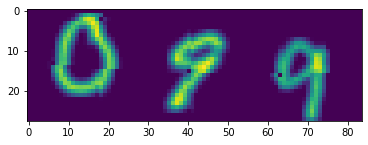

99


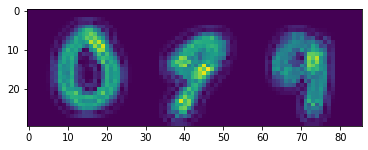

99


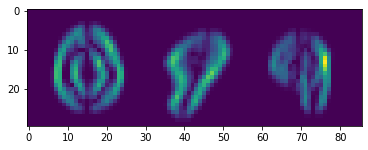

99


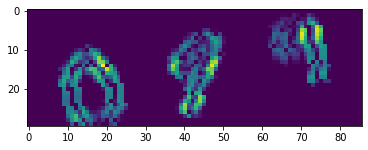

99


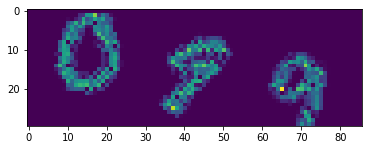

99


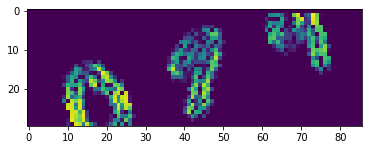

99


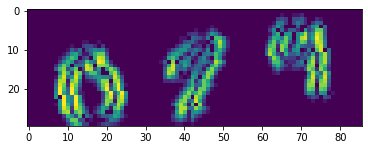

99


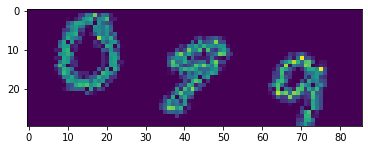

In [19]:
imgs = [new_cls[99][5][0]]
num = random.randint(0,100)
s_img = sampling(imgs) # Creating all samples

for num in s_img:
  print('99')
  print_num_fixed(num)

## **Task \#2: Shapes Dataset**

#### **Constants**

In [20]:
MIN_AREA = 100  # pixels
MAX_AREA = 600  # pixels
IMG_DIM = (50, 50, 3)

### **Shapes**

#### **Shape Class**
All three shapes will be implemented by it

In [21]:
class Shape:
  def __init__(self, size, location, oriantation, color):
    self.sp_size = size
    self.sp_location = location
    self.sp_oriantation = oriantation
    self.sp_color = color

  # Function for inherets.
  def create_image(self): # Will return the image
    pass

#### **Triangle**

In [22]:
# Triangle --> size: [p1, p2, p3], location + oriantation: irrelevant
class Triangle(Shape): # We Will calculate by given 3 vertexs
  def __init__(self):
    area = 0
    while area < 100 or area > 600:
      p1_x = random.randint(0,50)
      p1_y = random.randint(0,50)
      p2_x = random.randint(0,50)
      p2_y = random.randint(0,50)
      p3_x = random.randint(0,50)
      p3_y = random.randint(0,50)
      area = 0.5 * (p1_x * (p2_y - p3_y) + p2_x * (p3_y - p1_y) + p3_x * (p1_y - p2_y)) 
    pts = np.array(([p1_x, p1_y],[p2_x, p2_y],[p3_x,   p3_y]),np.int32)
    pts = [pts.reshape((-1,1,2))]
    r, g, b = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
    oriantation = random.randint(0, 360)
    super().__init__(pts, 0, oriantation, color=(r, g, b))
  
  def create_image(self):
    img = np.zeros((IMG_DIM[0], IMG_DIM[1]), np.int32)
    traingle = cv2.polylines(img, self.sp_size, True , self.sp_color, 1)
    return rotate(cv2.fillPoly(img, pts=self.sp_size, color=self.sp_color), self.sp_oriantation)

##### Triangle building try:

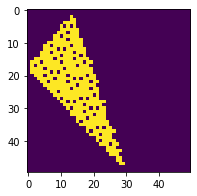

In [23]:
fig = plt.figure(figsize=(3, 3))
t = Triangle()
plt.imshow(t.create_image())

#### **Rectangle**

In [24]:
# Rctangle --> location [x_upper_left, y_upper_left], size (hight, width)
class Rectangle(Shape): 
  def __init__(self):
    h = random.randint(2, IMG_DIM[0]/2)
    high = 50
    h_s = 30
    max_val =  int(math.sqrt((abs(high-h_s))))
    if max_val > 49:
      max_val = 49 
    min_val = 1
    w = random.randint(min_val, max_val)
    oriantation = random.randint(0, 360)
    distance = int(math.sqrt(math.pow(h, 2) + math.pow(w, 2)))
    pos_x = random.randint(distance, IMG_DIM[0]-distance)
    pos_y = random.randint(distance, IMG_DIM[1]-distance)
    pos1 = (pos_x, pos_y)
    pos2 = (pos_x + w, pos_y+h)
    pos = (pos1,pos2)
    r, g, b = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
    super().__init__(h*w, pos, oriantation, color=(r, g, b))

  def create_image(self):
    img = np.zeros((IMG_DIM[0], IMG_DIM[1]), np.uint8)
    cv2.rectangle(img, self.sp_location[0], self.sp_location[1] , self.sp_color, -1)
    return rotate(img, self.sp_oriantation)

##### Rectangle building try:

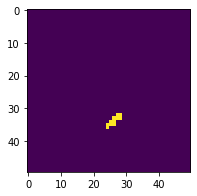

In [25]:
fig = plt.figure(figsize=(3, 3))
r = Rectangle()
plt.imshow(r.create_image())

#### **Circle**

In [26]:
# Circle --> size: (int) radious , location: ([int, int]) center 
class Circle(Shape): 
  
  def __init__(self):
    # Min\Max Radius
    MIN_RADIUS = int(math.sqrt(int(MIN_AREA/math.pi)+1)) # 100 /2Pi = 16
    MAX_RADIUS = int(math.sqrt(int(MAX_AREA /math.pi)-1)) # 600 / 2Pi = 95
    
    rds = random.randint(MIN_RADIUS, MAX_RADIUS)
    pos_x = random.randint(rds+1, IMG_DIM[0] - (rds+1))
    pos_y = random.randint(rds+1, IMG_DIM[1] - (rds+1))
    pos = (pos_x, pos_y)
    oriantation = random.randint(0, 360)
    r, g, b = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
    super().__init__(rds, pos, oriantation, color=(r,g,b))

  def create_image(self):
    img = np.zeros((IMG_DIM[0], IMG_DIM[1]), np.uint8)
    return cv2.circle(img, self.sp_location, self.sp_size, self.sp_color, -1)

##### Circle building try:

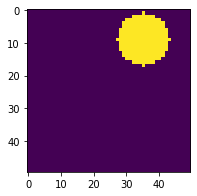

In [27]:
fig = plt.figure(figsize=(3, 3))
c = Circle()
plt.imshow(c.create_image())

### **Create Dataset**

In [28]:
def dataset_creation(shape): # { triangle: i = 0 , rectangle: i = 1, circle: i = 2}
  s_data = []
  for i in range(3):
    for j in range(300):
      if i == 0:
        shp = Triangle()
      elif i == 1: 
        shp = Rectangle()
      else: # i = 2
        shp = Circle()
      s_data.append((shp.create_image(), str(type(shp).__name__)))
  return s_data

Load Data:

In [29]:
class Data(Dataset):
  def __init__(self):
    self.len = 300
  
  def load_data(self):
    items = list()
    x_train, y_train = [], []
    x_test, y_test = [], []
    for i in range(300):
      items.append((0, Triangle()))
      items.append((1, Rectangle()))
      items.append((2, Circle()))
    random.shuffle(items)
    l = int(len(items) * 0.9)
    print(l)
    train, test = items[:l], items[l:]
    for y, x in train: 
      x_train.append(x)
      y_train.append(y)
    for y, x in test: 
      x_test.append(x)
      y_test.append(y)
    return (x_train, y_train), (x_test, y_test)

In [30]:
data = Data()
(x_train, y_train), (x_test, y_test) = data.load_data()

810


#### **Display from train**

##### Disply Triangle:

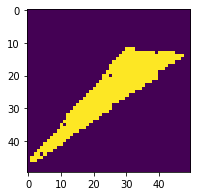

In [31]:
n = random.randint(0, 299)
while(y_train[n]) != 0:
  n = random.randint(0, 299)
fig = plt.figure(figsize=(3, 3))
plt.imshow(x_train[n].create_image())

##### Disply Rectangle:

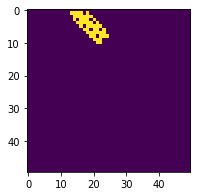

In [32]:
n = random.randint(0, 299)
while(y_train[n]) != 1:
  n = random.randint(0, 299)
fig = plt.figure(figsize=(3, 3))
plt.imshow(x_train[n].create_image())

##### Display circle

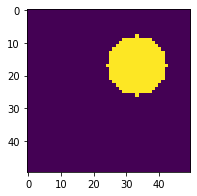

In [33]:
n = random.randint(0, 299)
while(y_train[n]) != 2:
  n = random.randint(0, 299)
fig = plt.figure(figsize=(3, 3))
plt.imshow(x_train[n].create_image())

## **Summary**

In this work, we studied to work with mnist data, and summation all the subjcets we studied from the start of the class.

We used our filters, we've addited images and created new ones. Also, we created dataset from given datasets (and from scratch)